In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature

In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, 'is_train', 'date']

def filter_feature(path):
    if \
    path.count('') \
    :
#     and not path.count('raw__D') \
#     and not path.count('raw__C') \
#     and not path.count('raw__V') \
#     or path.count('Fraud') 
#     or path.count('tionID') 
#     or path.count('C1')
#     or path.count('C13')
#     or path.count('V232')
#     or path.count('addr1')
        return True
    else:
        return False
    

paths_train = glob('../feature/raw_use/*_train.gz')
paths_train = [path for path in paths_train if filter_feature(path) ]
paths_test = glob('../feature/raw_use/*_test.gz')
paths_test = [path for path in paths_test if filter_feature(path) ]

paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

paths_train_feature += glob('../feature/valid/*_train.gz')
paths_test_feature += glob('../feature/valid/*_test.gz')

In [3]:
df_train = reduce_mem_usage( parallel_load_data(paths_train) )
df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

Memory usage of dataframe is 127.28 MB
Memory usage after optimization is: 120.52 MB
Decreased by 5.3%
Memory usage of dataframe is 327.14 MB
Memory usage after optimization is: 375.46 MB
Decreased by -14.8%


  3%|▎         | 2/59 [00:00<00:02, 19.83it/s]

* Check Unique Feature.


100%|██████████| 59/59 [00:00<00:00, 65.90it/s]


All Features have info.
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.93311
[400]	valid_0's auc: 0.942216
[600]	valid_0's auc: 0.945732
[800]	valid_0's auc: 0.947298
Early stopping, best iteration is:
[866]	valid_0's auc: 0.948011
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.926869
[400]	valid_0's auc: 0.935641
[600]	valid_0's auc: 0.940332
Early stopping, best iteration is:
[646]	valid_0's auc: 0.941006
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.930701
[400]	valid_0's auc: 0.939071
[600]	valid_0's auc: 0.942188
[800]	valid_0's auc: 0.944096
Early stopping, best iteration is:
[908]	valid_0's auc: 0.945004
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.922915
[400]	valid_0's auc: 0.931494
[600]	valid_0's auc: 0.937215
[800]	valid_0's auc: 0.93962
Early stopping, best iteration is:
[753]	valid_0's auc: 0.939855
Training until valid

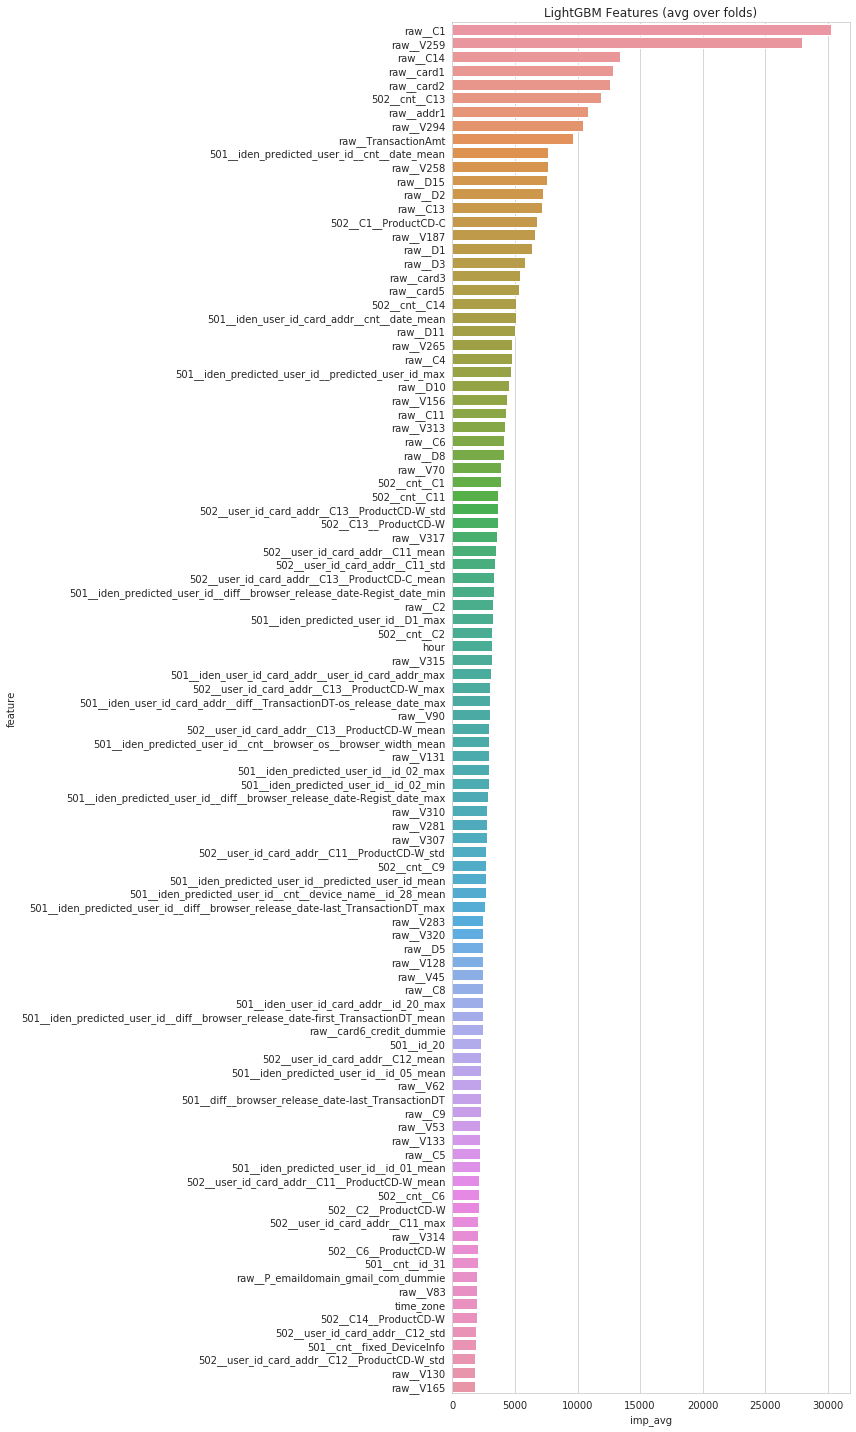

Setup Dataset dim_ml_dataset.


In [4]:
list_feim = []
for i in range(1, 2, 1):
    
#     valid_paths_train = paths_train_feature[i*800:(i+1)*800]
#     valid_paths_test  = paths_test_feature[i*800:(i+1)*800]
    valid_paths_train = paths_train_feature
    valid_paths_test  = paths_test_feature
    
    #========================================================================
    # pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
    #========================================================================
    remove_paths = []
    for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
        if os.path.exists(trn_path) and os.path.exists(tes_path):
            pass
        else:
            remove_paths.append(trn_path)
            remove_paths.append(tes_path)
    for path in remove_paths:
        if path.count('train'):
            valid_paths_train.remove(path)
            print(f'remove {path}')
        elif path.count('test'):
            valid_paths_test.remove(path)
            print(f'remove {path}')
    
#     df_feat_train = reduce_mem_usage( parallel_load_data(valid_paths_train) )
#     df_feat_test  = reduce_mem_usage( parallel_load_data(valid_paths_test) )
    df_feat_train = parallel_load_data(valid_paths_train)
    df_feat_test  = parallel_load_data(valid_paths_test)
    
    col_drops = eval_check_feature(df_feat_train, df_feat_test)
    
    tmp_train = df_train.join(df_feat_train)
    tmp_test = df_test.join(df_feat_test)
    
    #========================================================================
    # Train Test で片方に存在しないFeatureを除外
    #========================================================================
    diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))
    for col in list(set(diff_cols)):
        if col.count('raw'):
            from_dir = 'raw_use'
            to_dir = 'raw_trush'
        else:
            from_dir = 'org_use'
            to_dir = 'org_trush'
        move_feature([col], from_dir, to_dir)
    tmp_train.drop(diff_cols, axis=1, inplace=True)
    
    # same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
    same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
    model_type = "lgb"
    params = {
        'n_jobs': 60,
        'seed': 1208,
        'n_splits': 5,
        'metric': 'auc',
        'model_type': model_type,
        'objective': 'binary',
        'fold': ['stratified', 'group'][1],
        'num_leaves': 2**6-1,
        'max_depth': 8,
        'subsample': 0.75,
        'subsample_freq': 2,
        'colsample_bytree' : 0.20,
        'lambda_l1' : 0.1,
        'lambda_l2' : 1.0,
        'learning_rate' : 0.1,
    }
    list_result_feim = eval_train(
        tmp_train,
        Y,
        tmp_test,
        same_user_path,
        model_type,
        params,
        is_adv=[True, False][1],
        is_viz=[True, False][0],
    )
    list_feim.append(list_result_feim)
    
#     feim = list_result_feim[0]
#     max_imp = feim['imp_avg'].max()
#     thres_imp = max_imp/100
#     thres_imp = max_imp/25
#     for feature_name in feim[feim['imp_avg']<thres_imp].index:
#         if feature_name.count('raw'):
#             from_dir = 'raw_use'
#             to_dir = 'raw_trush'
#         else:
#             from_dir = 'org_use'
#             to_dir = 'org_trush'
#         try:
#             move_feature([feature_name], from_dir, to_dir)
#         except FileNotFoundError:
#             print(feature_name)

In [6]:
feim = list_result_feim[0]
feim.head(100)
feim.tail(50)

,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,imp_avg
feature,,,,,,
raw__card6_debit_dummie,1589.732056,1624.635986,2044.417236,1778.793579,1748.257690,1757.167236
raw__V306,1748.919189,1761.907104,1700.590698,1652.513672,1860.915771,1744.969360
raw__V308,1726.695801,1695.564087,1963.617432,1626.772827,1675.037598,1737.537476
raw__V87,1522.814819,1611.203125,1617.534424,1523.314087,1840.219238,1623.017212
raw__V312,1622.015991,1400.877075,1637.221313,1596.281006,1843.239624,1619.927002
raw__V61,1677.246338,1541.124146,1700.573364,1418.501465,1754.432495,1618.375610
raw__R_emaildomain_gmail_com_dummie,1334.932129,1502.095703,1335.744507,1551.190430,2160.988525,1576.990234
raw__V44,1508.426636,1137.340698,1904.082031,1986.838257,1318.593384,1571.056274
501__cnt__DeviceInfo,1348.257446,1794.301636,1638.212402,1460.585693,1533.382446,1554.947998


In [7]:
pd.set_option('max_rows', 300)
# best_feim = read_pkl_gzip('../output/feature_importances/20190903_1520__CV0-9474818622326217__feature743.gz')
for feature_name in feim[feim['imp_avg']<1000].index:
# for feature_name in best_feim.index:
    if feature_name.count('raw'):
        from_dir = 'raw_use'
#         to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
#         to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
#     from_dir = 'valid'
    to_dir = 'valid_trush'
    try:
        move_feature([feature_name], from_dir, to_dir)
    except FileNotFoundError:
        print(feature_name)

raw__P_emaildomain_anonymous_com_dummie
raw__R_emaildomain_anonymous_com_dummie
raw__P_emaildomain_yahoo_com_dummie
raw__P_emaildomain_hotmail_com_dummie
raw__P_emaildomain_mail_com_dummie
raw__R_emaildomain_hotmail_com_dummie
raw__P_emaildomain_msn_com_dummie


In [7]:
feim.shape

(230, 6)